In [1]:
import torch
import os
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from model import VQVAE
from dataset import ECGDataset
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = ECGDataset('./data/ECG5000_TEST.txt')

test_loader = DataLoader(test_dataset, batch_size=232, shuffle=False)

Data frame shape: (4499, 141)
Number of samples: 4499


In [3]:
# 加载模型
model = VQVAE(in_channel=1, channel=64, n_res_block=1, n_res_channel=16, embed_dim=32, n_embed=256).to(device)
model.load_state_dict(torch.load('checkpoint/vqvae_1000.pt'))

<All keys matched successfully>

In [4]:
def extract_features(loader, model, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            max_len = 134
            data = data[:, :, :max_len]
            _, quant_b, _, _, _ = model.encode(data)
            features.append(quant_b.cpu().numpy())
            labels.append(label.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [5]:
features, labels = extract_features(test_loader, model, device)

/data1/wanghy/anaconda3/envs/llm_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [6]:
# 使用PCA进行降维
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features.reshape(features.shape[0], -1))


In [7]:
# 使用t-SNE进行降维
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features.reshape(features.shape[0], -1))


In [20]:
def plot_embedding(features, labels, title):
    plt.figure(figsize=(12, 12))
    
     # 使用seaborn的scatterplot绘制散点图
    palette = sns.color_palette("tab10", n_colors=len(set(labels)))
    scatter = sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette=palette, s=40, edgecolor='w', alpha=0.7)
    
    # 设置标题和轴标签
    plt.title(title, fontsize=20, weight='bold')
    plt.xlabel("Component 1", fontsize=15)
    plt.ylabel("Component 2", fontsize=15)
    
    # 美化图例
    legend = scatter.legend(title='Class', title_fontsize='13', fontsize='11', loc='best', borderpad=1, frameon=True)
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(0.8)
    
    # 美化网格
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 美化轴
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(1.2)
    plt.gca().spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    plt.show()

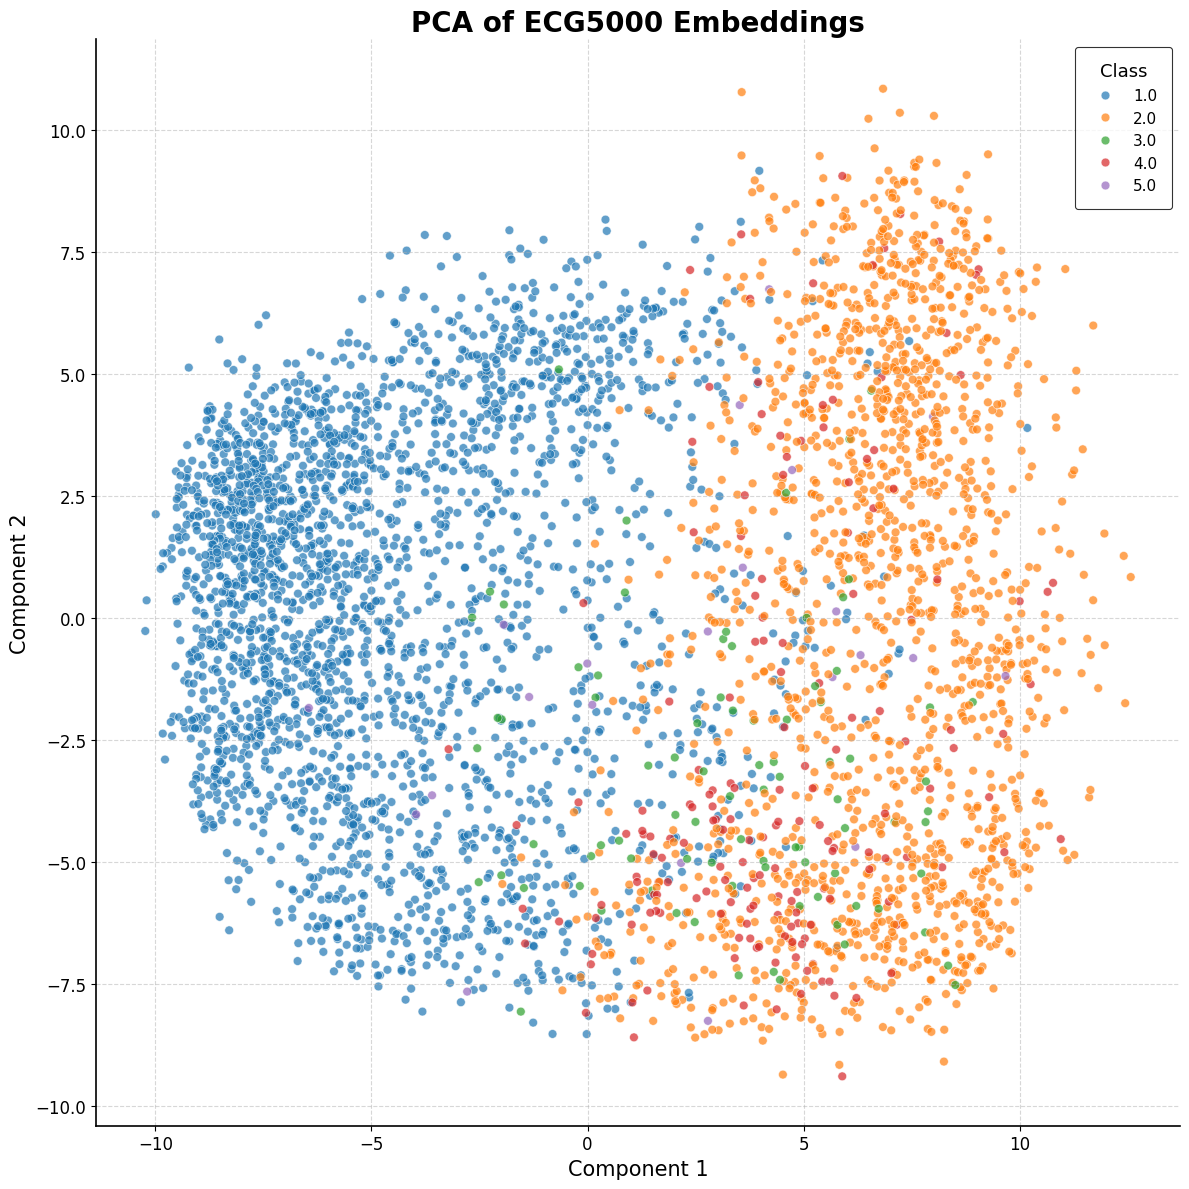

In [21]:
# 绘制PCA结果
plot_embedding(features_pca, labels, 'PCA of ECG5000 Embeddings')

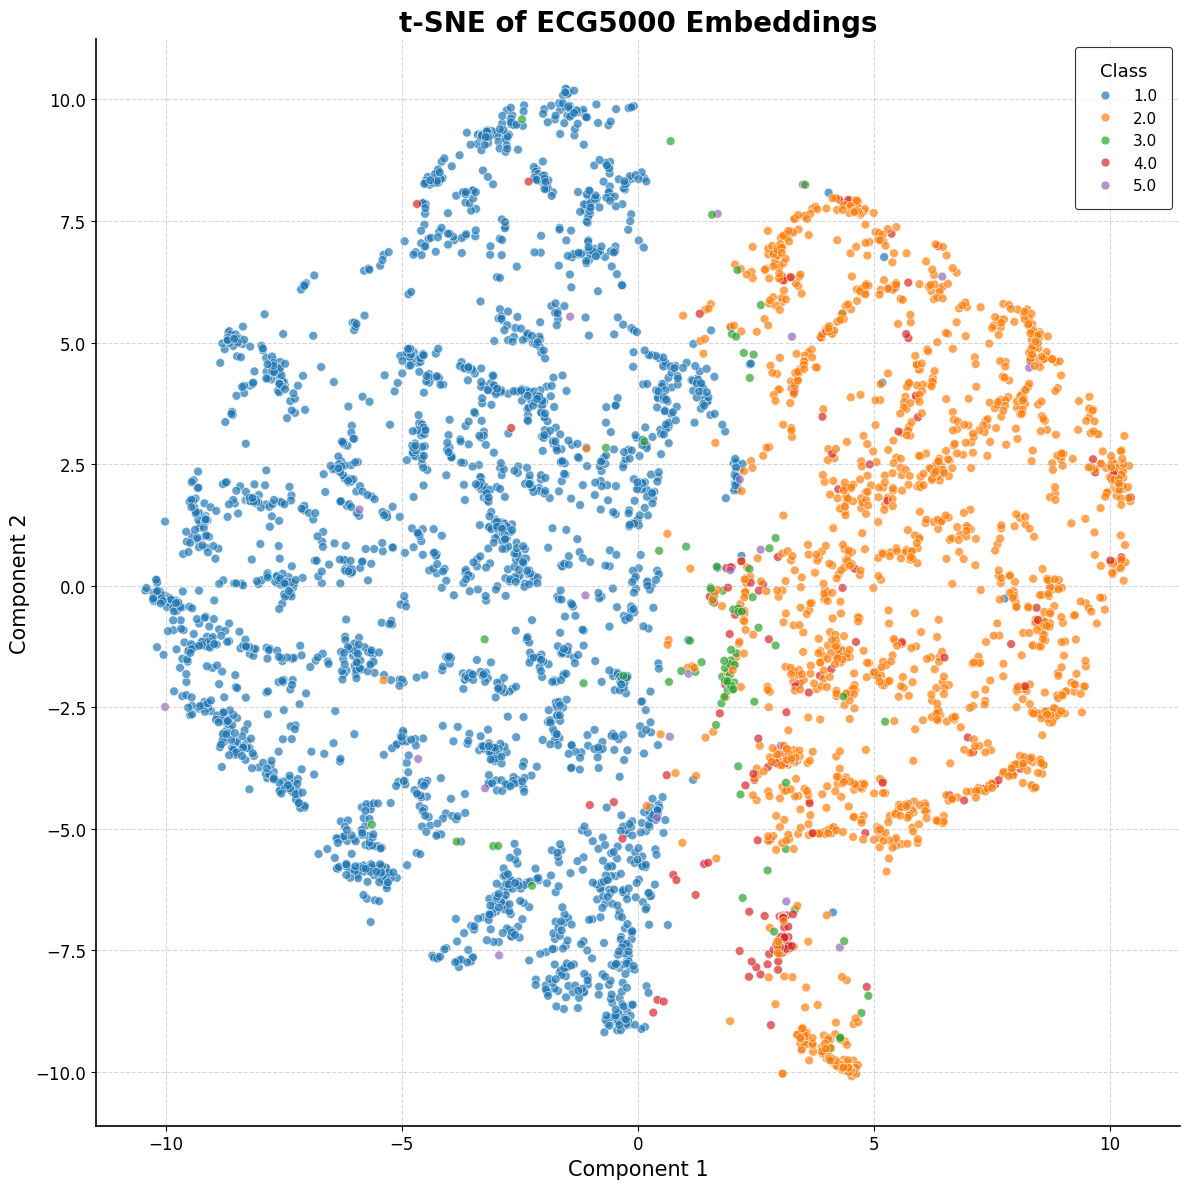

In [22]:
# 绘制t-SNE结果
plot_embedding(features_tsne, labels, 't-SNE of ECG5000 Embeddings')